<a href="https://colab.research.google.com/github/olliwho/outlier_detection/blob/main/IaVU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code to install additional alibi_detect library in colab

In [1]:
!pip install alibi_detect

### Imports

In [23]:
from alibi_detect.models import PixelCNN
from alibi_detect.models.losses import elbo
from alibi_detect.models.autoencoder import eucl_cosim_features
from alibi_detect.od import OutlierVAE, OutlierVAEGMM, LLR
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils import visualize as viz
from alibi_detect.utils.perturbation import apply_mask

import tensorflow as tf
from tensorflow.python.keras.engine.input_layer import InputLayer
from tensorflow.python.keras.layers import Conv2D, Dense, Reshape, Conv2DTranspose

import os
import matplotlib.pyplot as plt
import numpy as np
import random

from google.colab import drive

Mount Drive and set paths

In [3]:
if 'google.colab' in str(get_ipython()):
    drive.mount('/content/drive')
    path = "/content/drive/MyDrive/detectors"
    plots_path = "/content/drive/MyDrive/plots"
    print('Running on CoLab')
else:
    print('Not running on CoLab')
    path = "./detectors"
    plots_path = "./plots"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running on CoLab


Check if GPU acceleration is enabled

In [4]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Part 1

In the first part, we train 3 detectors with the Cifar10 dataset. one VAE, one VAEGMM and one LR.

### Load the datasets

In [30]:
dataset = 'cifar10'
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X = X_train[:500]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X.shape)

input_shape=X_train.shape[1:]

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)
(500, 32, 32, 3)


## VAE


In [31]:
load = False

In [ ]:
epochs = 50
th = 0.1
s = 2
ld = 1024
bs = 56

if load:
    od_v = load_detector(os.path.join(path, 'OutlierVAE_Cifar10'))
else:
    encoder = tf.keras.Sequential([InputLayer(input_shape=input_shape),
                            Conv2D(32, 4, strides=2, padding='same', activation=tf.nn.relu),
                            Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
                            Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
                            ])
    
    decoder = tf.keras.Sequential([InputLayer(input_shape=(ld,)),
                            Dense(4*4*128),
                            Reshape(target_shape=(4, 4, 128)),
                            Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
                            Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
                            Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
                            ])

    od_v = OutlierVAE(threshold=None, 
                        score_type='mse', 
                        encoder_net=encoder,
                        decoder_net=decoder, 
                        latent_dim=ld, 
                        samples=s)


    od_v.fit(X_train, 
                loss_fn=elbo,
                cov_elbo=dict(sim=.05), 
                epochs=epochs, 
                batch_size=bs,
                verbose=True)

    od_v.infer_threshold(X, threshold_perc=99)  # assume 1% of the training data are outliers
    print('New threshold: {}'.format(od_v.threshold))

    save_detector(od_v, os.path.join(path, 'OutlierVAE_Cifar10'))


## VAEGMM

In [33]:
load = False

In [ ]:
epochs = 50
th = 0.1
s = 2 
ld = 4
n_gmm = 2
bs = 64

if load:
    od_vg = load_detector(os.path.join(path, 'OutlierVAEGMM_Cifar10'))
else:
    encoder = tf.keras.Sequential([InputLayer(input_shape=input_shape),
                            Conv2D(5, 4, strides=2, padding='same', activation=tf.nn.relu),
                            Conv2D(10, 4, strides=2, padding='same', activation=tf.nn.relu),
                            Conv2D(20, 4, strides=2, padding='same', activation=tf.nn.relu)
                            ])
    
    decoder = tf.keras.Sequential([InputLayer(input_shape=(ld,)),
                            Dense(4*4*128),
                            Reshape(target_shape=(4, 4, 128)),
                            Conv2DTranspose(20, 4, strides=2, padding='same', activation=tf.nn.relu),
                            Conv2DTranspose(10, 4, strides=2, padding='same', activation=tf.nn.relu),
                            Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
                            ])

    gmm_density = tf.keras.Sequential([InputLayer(input_shape=(ld + 2,)),
                                Dense(10, activation=tf.nn.relu),
                                Dense(n_gmm, activation=tf.nn.softmax)
                                ])

    od_vg = OutlierVAEGMM(threshold=None, 
                            encoder_net=encoder, 
                            decoder_net=decoder, 
                            gmm_density_net=gmm_density, 
                            latent_dim=ld, 
                            n_gmm=n_gmm, 
                            samples=s, 
                            recon_features=eucl_cosim_features)


    losses = od_vg.fit(X_train, 
                        cov_elbo=dict(sim=.05),
                        epochs=epochs, 
                        batch_size=bs, 
                        verbose=True)
    
    print(losses)

    od_vg.infer_threshold(X, threshold_perc=99)  # assume 1% of the training data are outliers
    print('New threshold: {}'.format(od_vg.threshold))

    save_detector(od_vg, os.path.join(path, 'OutlierVAEGMM_Cifar10'))

## LR

In [35]:
load = False

In [ ]:
model = PixelCNN(
    image_shape=input_shape,
    num_resnet=5,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=1,
    receptive_field_dims=(3, 3),
    dropout_p=.3,
    l2_weight=0.
)

if load:
    kwargs = {'dist_s': model, 'dist_b': model.copy(), 'input_shape': input_shape}
    od_lr = load_detector(os.path.join(path, "LR_Cifar10"), **kwargs)
else:
    od_lr = LLR(threshold=None, model=model)
    od_lr.fit(
            X_train,
            mutate_fn_kwargs=dict(rate=.2),
            mutate_batch_size=1000,
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            epochs=20,
            batch_size=32,
            verbose=True
        )
    
    od_lr.infer_threshold(X, threshold_perc=99)  # assume 1% of the training data are outliers
    print('New threshold: {}'.format(od_lr.threshold))

    save_detector(od_lr, os.path.join(path, 'LR_Cifar10'))

# Part 2

In this part, we train 3 detectors with the Fashion-MNIST dataset. One VAE, one VAEGMM and one LR.

### Load the dataset

In [37]:
def load_data(dataset: str) -> tuple:
    if dataset == 'mnist':
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    elif dataset == 'fashion_mnist':
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
        
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255
    y_train = y_train.astype('int64').reshape(-1,)
    y_test = y_test.astype('int64').reshape(-1,)
    if len(X_train.shape) == 3:
        shape = (-1,) + X_train.shape[1:] + (1,)
        X_train = X_train.reshape(shape)
        X_test = X_test.reshape(shape)
    return (X_train, y_train), (X_test, y_test)

(X_train_in, y_train_in), (X_test_in, y_test_in) = load_data('fashion_mnist')

X_train_in = np.pad(X_train_in,((0,0),(2,2),(2,2),(0,0)),constant_values=(0,))
X_test_in = np.pad(X_test_in,((0,0),(2,2),(2,2),(0,0)),constant_values=(0,))


X_test_ood, y_test_ood = load_data('mnist')[1]

X_test_ood = np.pad(X_test_ood, ((0,0),(2,2),(2,2),(0,0)), constant_values=(0,))


input_shape = X_train_in.shape[1:]

print(X_train_in.shape, X_test_in.shape, X_test_ood.shape)
print(y_train_in.shape, y_test_in.shape, y_test_ood.shape)

(60000, 32, 32, 1) (10000, 32, 32, 1) (10000, 32, 32, 1)
(60000,) (10000,) (10000,)


## VAE

In [39]:
load = False

In [ ]:
epochs = 50
th = 0.1
s = 2
ld = 1024
bs = 56

if load:
    od_v1 = load_detector(os.path.join(path, 'OutlierVAE_FMNIST'))
else:
    encoder = tf.keras.Sequential([InputLayer(input_shape=input_shape),
                            Conv2D(32, 4, strides=2, padding='same', activation=tf.nn.relu),
                            Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
                            Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
                            ])
    
    decoder = tf.keras.Sequential([InputLayer(input_shape=(ld,)),
                            Dense(4*4*128),
                            Reshape(target_shape=(4, 4, 128)),
                            Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
                            Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
                            Conv2DTranspose(1, 4, strides=2, padding='same', activation='sigmoid')
                            ])


    od_v1 = OutlierVAE(threshold=None, 
                        score_type='mse', 
                        encoder_net=encoder,
                        decoder_net=decoder, 
                        latent_dim=ld, 
                        samples=s)

    od_v1.fit(X_train_in, 
                loss_fn=elbo,
                cov_elbo=dict(sim=.05), 
                epochs=epochs, 
                batch_size=bs,
                verbose=True)

    save_detector(od_v1, os.path.join(path, 'OutlierVAE_FMNIST'))


## VAEGMM

In [43]:
load = False

In [ ]:
epochs = 50
th = 0.1
s = 2 
ld = 4
n_gmm = 2
bs = 64

if load:
    od_vg1 = load_detector(os.path.join(path, 'OutlierVAEGMM_FMNIST'))
else:
    encoder = tf.keras.Sequential([InputLayer(input_shape=input_shape),
                            Conv2D(5, 4, strides=2, padding='same', activation=tf.nn.relu),
                            Conv2D(10, 4, strides=2, padding='same', activation=tf.nn.relu),
                            Conv2D(20, 4, strides=2, padding='same', activation=tf.nn.relu)
                            ])
    
    decoder = tf.keras.Sequential([InputLayer(input_shape=(ld,)),
                            Dense(4*4*128),
                            Reshape(target_shape=(4, 4, 128)),
                            Conv2DTranspose(20, 4, strides=2, padding='same', activation=tf.nn.relu),
                            Conv2DTranspose(10, 4, strides=2, padding='same', activation=tf.nn.relu),
                            Conv2DTranspose(1, 4, strides=2, padding='same', activation='sigmoid')
                            ])

    gmm_density = tf.keras.Sequential([InputLayer(input_shape=(ld + 2,)),
                                Dense(10, activation=tf.nn.relu),
                                Dense(n_gmm, activation=tf.nn.softmax)
                                ])

    od_vg1 = OutlierVAEGMM(threshold=None, 
                            encoder_net=encoder, 
                            decoder_net=decoder, 
                            gmm_density_net=gmm_density, 
                            latent_dim=ld, 
                            n_gmm=n_gmm, 
                            samples=s, 
                            recon_features=eucl_cosim_features)


    od_vg1.fit(X_train_in, 
                cov_elbo=dict(sim=.05),
                epochs=epochs, 
                batch_size=bs, 
                verbose=True)

    save_detector(od_vg1, os.path.join(path, 'OutlierVAEGMM_FMNIST'))

## LR

In [45]:
load = False

In [ ]:
model = PixelCNN(
    image_shape=input_shape,
    num_resnet=5,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=1,
    receptive_field_dims=(3, 3),
    dropout_p=.3,
    l2_weight=0.
)

if load:
    kwargs = {'dist_s': model, 'dist_b': model.copy(), 'input_shape': input_shape}
    od_lr1 = load_detector(os.path.join(path, "LR_FMNIST"), **kwargs)
else:
    od_lr1 = LLR(threshold=None, model=model)
    od_lr1.fit(
            X_train_in,
            mutate_fn_kwargs=dict(rate=.2),
            mutate_batch_size=1000,
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            epochs=20,
            batch_size=32,
            verbose=True
        )
    save_detector(od_lr1, os.path.join(path, 'LR_FMNIST'))

# Visualizations

In the next section we can see some visualizations done on the datasets and detectors, but without predicting anything.

## Cifar 10

Showing a random sample of pictures from the dataset.

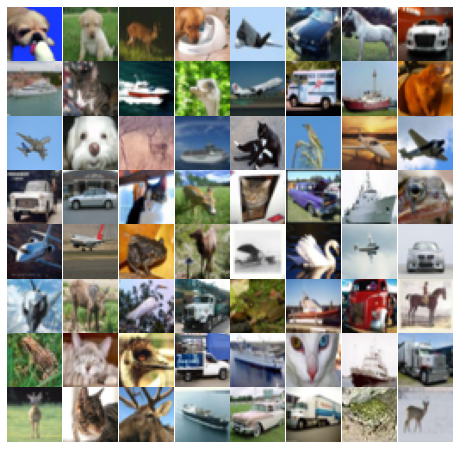

In [47]:
randoms = [[random.randint(0, len(X_train)-1)] for _ in range(64)]
plt.figure(figsize=(8,8), frameon=False)
for i, idx in enumerate(randoms):
    plt.subplot(8,8,i+1)
    x = X_train[idx].reshape(1, 32, 32, 3)
    plt.imshow(x.reshape(32, 32, 3))
    plt.axis('off')
plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig(os.path.join(plots_path, "cifar10"))
plt.show()

A picture from the dataset vs. the same picture perturbed for the first experiment.

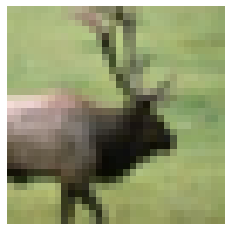

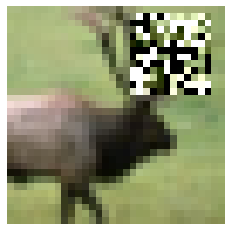

In [24]:
x = X_train[34].reshape(1, 32, 32, 3)
x_mask, mask = apply_mask(x, mask_size=(12, 12), n_masks=1, channels=[0,1,2], 
                          mask_type='normal', noise_distr=(0,1), clip_rng=(0,1))
plt.imshow(x.reshape(32, 32, 3))
plt.axis('off')
plt.savefig(os.path.join(plots_path, "normal.png"))
plt.show()
plt.imshow(x_mask.reshape(32, 32, 3))
plt.axis('off')
plt.savefig(os.path.join(plots_path, "preturbed.png"))
plt.show()

## (Fashion-)MNIST

Showing a random sample of pictures from both datasets.

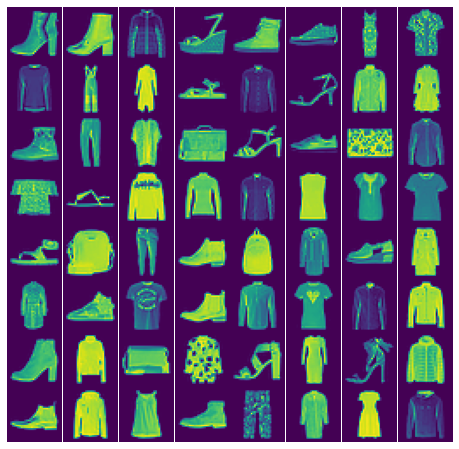

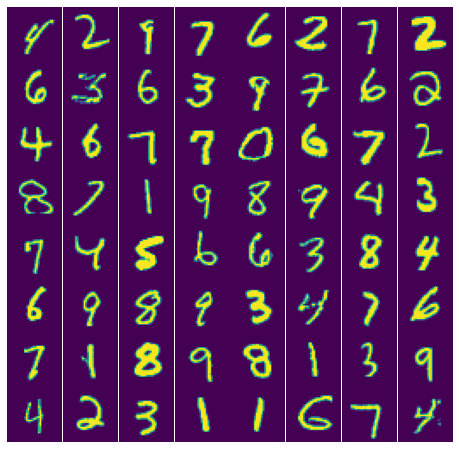

In [25]:
randoms = [[random.randint(0, len(X_train_in)-1)] for _ in range(64)]
plt.figure(figsize=(8,8), frameon=False)
for i, idx in enumerate(randoms):
    plt.subplot(8,8,i+1)
    x = X_train_in[idx].reshape(1, 32, 32, 1)
    plt.imshow(x.reshape(32, 32))
    plt.axis('off')
plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig(os.path.join(plots_path, "f_mnist"))
plt.show()

randoms = [[random.randint(0, len(X_test_ood)-1)] for _ in range(64)]
plt.figure(figsize=(8,8), frameon=False)
for i, idx in enumerate(randoms):
    plt.subplot(8,8,i+1)
    x = X_test_ood[idx].reshape(1, 32, 32, 1)
    plt.imshow(x.reshape(32, 32))
    plt.axis('off')
plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig(os.path.join(plots_path, "mnist"))
plt.show()